In [2]:
import xgboost as xgb
import os
import pandas as pd
import cudf
import cupy as cp
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

"""
    This mirrors most of what is at the end of ontime/src/eda.ipynb. However, in order to be executed without the overhead of a jupyter server (this is training on a laptop)
"""

DATA_PATH = 'data'
RES_PATH = '../res'

# Read and select appropriate columns
df = cudf.read_csv(os.path.join(RES_PATH, 'selected.csv'),index=False)

data = df.loc[:, [
    'ActualElapsedTime',
    'AirTime',
    'ArrDel15',
    'CRSArrTime',
    'CRSDepTime',
    'CRSElapsedTime',
    'DayOfWeek',
    'DepDel15',
    'DepDelayMinutes',
    'DepTime',
    'Dest',
    'DestState',
    'DistanceGroup',
    'Flights',
    'Origin',
    'OriginState',
    'Quarter',
    'TaxiOut',
    'WheelsOff',
    'WheelsOn'
]]
# remove all null values
data = data[
    data.DestState.notna() & 
    data.ActualElapsedTime.notna() &
    data.AirTime.notna() &
    data.ArrDel15.notna() &
    data.TaxiOut.notna() &
    data.WheelsOff.notna() &
    data.WheelsOn.notna()]

# control fro negative values
data = data.loc[(data.ActualElapsedTime > 0) & (data.AirTime > 0)]

data.loc[data['DepDel15'].isna()] = 0.0
# convert to categorical
data['ArrDel15'] = pd.Categorical(data['ArrDel15'].to_array())
data['DepDel15'] = pd.Categorical(data['DepDel15'].to_array())

data['DayOfWeek'] = pd.Categorical(data['DayOfWeek'].to_array())
data['Dest'] = pd.Categorical(data['Dest'].to_array())
data['DestState'] = pd.Categorical(data['DestState'].to_array())
data['DistanceGroup'] = pd.Categorical(data['DistanceGroup'].to_array())
data['Origin'] = pd.Categorical(data['Origin'].to_array())
data['OriginState'] = pd.Categorical(data['OriginState'].to_array())
data['Quarter'] = pd.Categorical(data['Quarter'].to_array())


columns = ['ActualElapsedTime', 'AirTime', 'CRSArrTime', 'CRSDepTime',
       'CRSElapsedTime', 'DayOfWeek', 'DepDel15', 'DepDelayMinutes', 'DepTime',
       'DistanceGroup', 'Flights', 'Quarter', 'TaxiOut', 'WheelsOff', 'WheelsOn']

data[columns] = data[columns].astype('int32')
dest_cat = dict(enumerate(data.to_pandas()['Dest'].cat.categories))
deststate_cat = dict(enumerate(data.to_pandas()['DestState'].cat.categories))
origin_cat = dict(enumerate(data.to_pandas()['Origin'].cat.categories))
originstate_cat = dict(enumerate(data.to_pandas()['OriginState'].cat.categories))


data['Dest_enc'] = data['Dest'].cat.codes
data['DestState_enc'] = data['DestState'].cat.codes
data['Origin_enc'] = data['Origin'].cat.codes
data['OriginState_enc'] = data['OriginState'].cat.codes

data = data.drop(['Dest', 'DestState', 'Origin', 'OriginState'], axis=1)
data['ArrDel15'] = data['ArrDel15'].astype('uint8')


# Training the Random Forest
# instantiate params
params = {}

# booster params
n_gpus = 1
booster_params = {}

if n_gpus != 0:
    booster_params['tree_method'] = 'gpu_hist'
    booster_params['num_parallel_tree'] = 15
#     booster_params['n_gpus'] = n_gpus
params.update(booster_params)

# learning task params
learning_task_params = {'eval_metric': 'auc', 'objective': 'binary:logistic'}
params.update(learning_task_params)

target = data['ArrDel15']
data = data.drop('ArrDel15', axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=42, shuffle=True)


dtrain = xgb.DMatrix(X_train, y_train)
bst = xgb.train(params, dtrain)

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)
y_test_pred = xg_reg.predict(X_test)

mse = mean_squared_error(y_test_pred, y_test.to_array())
print(mse)


[16:34:18] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1618854806953/work/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
0.10081876


<AxesSubplot:>

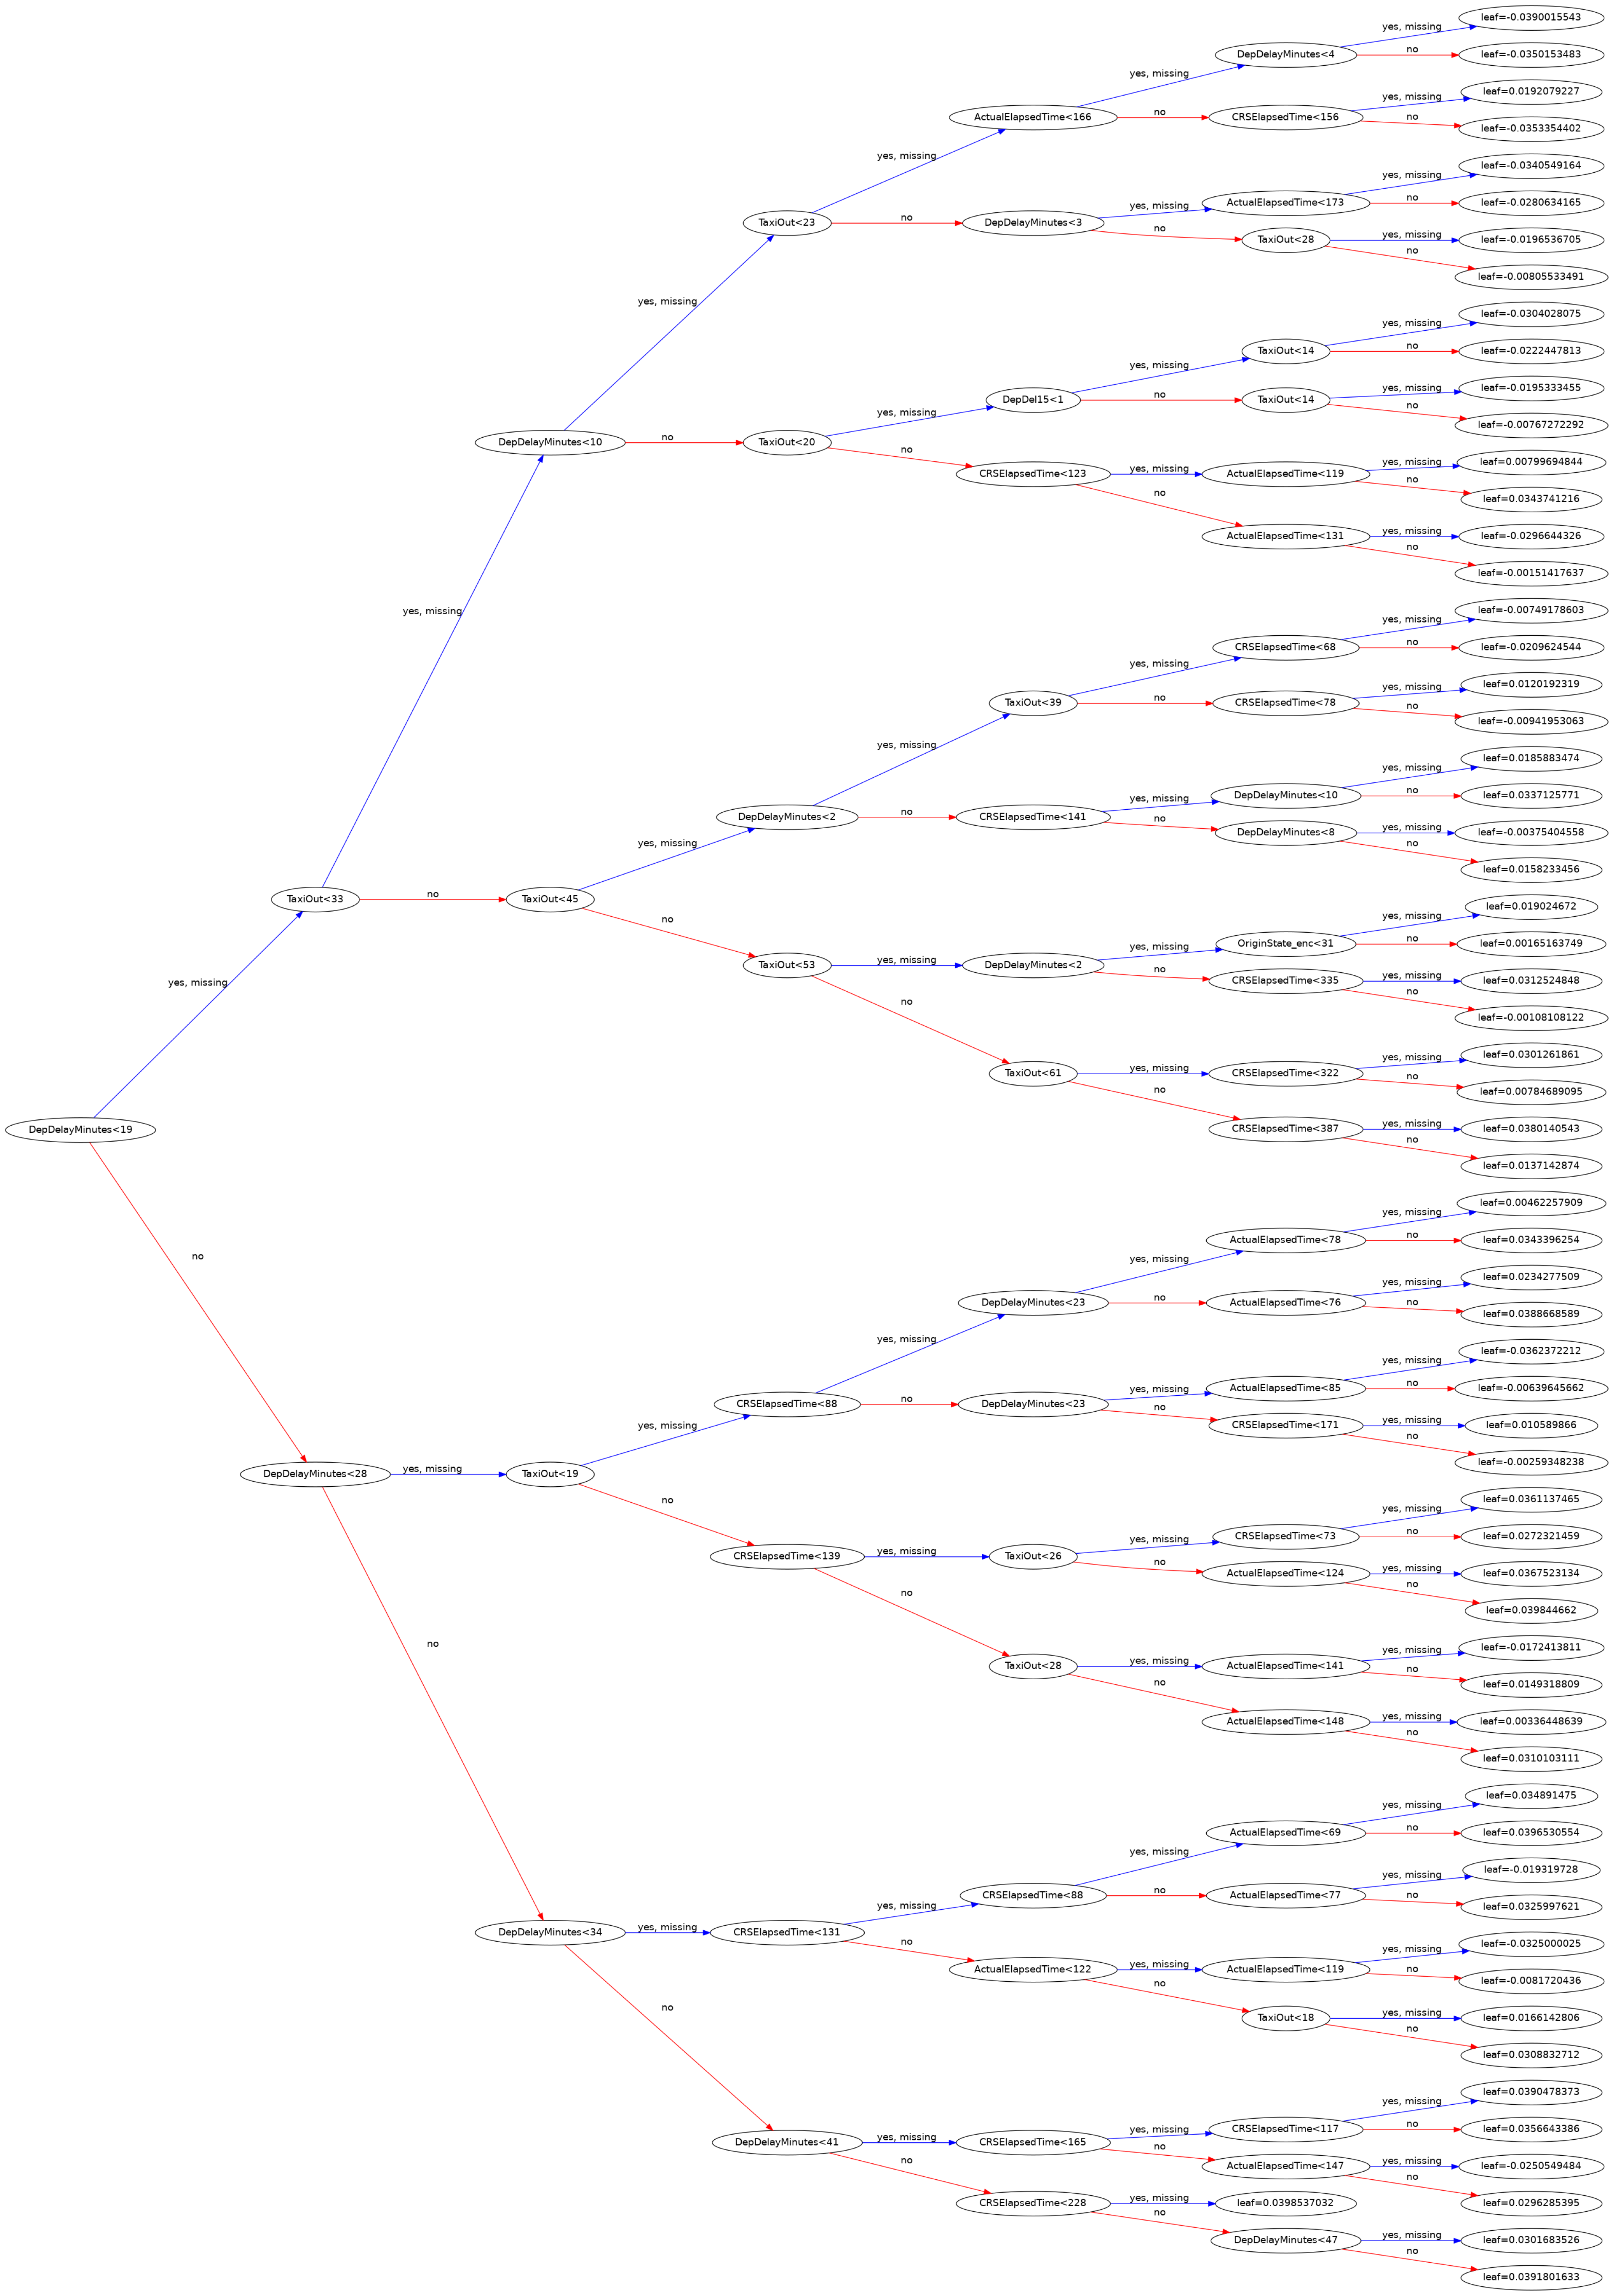

In [25]:
from xgboost import plot_tree
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(100, 100))
xgb.plot_tree(bst, ax=ax, rankdir='LR', num_trees=4)
